In [4]:
%pylab inline
import pandas as pd
import xarray as xr
from pyproj import Transformer

import plotly.express as px

Populating the interactive namespace from numpy and matplotlib


In [5]:
smi = xr.open_dataset('./observation_based/SMI_v2.nc')

/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'lat' has multiple fill values {-9999.0, '-9999.000000'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'lon' has multiple fill values {-9999.0, '-9999.000000'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [6]:
smi

/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (time: 3058, xc: 100, yc: 95)
Coordinates:
  * time     (time) datetime64[ns] 1766-01-31 1766-02-28 ... 2020-10-31
  * xc       (xc) float32 2.525e+06 2.575e+06 2.625e+06 ... 7.425e+06 7.475e+06
  * yc       (yc) float32 5.475e+06 5.425e+06 5.375e+06 ... 8.25e+05 7.75e+05
Data variables:
    SMI      (time, yc, xc) float32 ...
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Jul 07 19:27:07 2022: cdo -f nc4c -z zip_4 -b F32 copy ...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

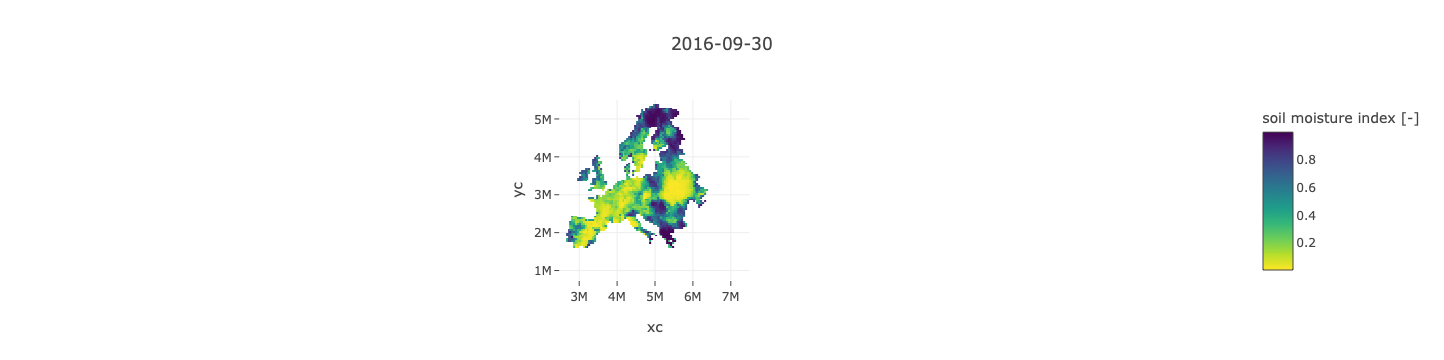

In [79]:
px.imshow(smi.SMI[-50],x=smi.xc,y=smi.yc, origin='lower', aspect='equal', template='none', color_continuous_scale='viridis_r', title=str(pd.to_datetime(smi.time[-50].values).date()))

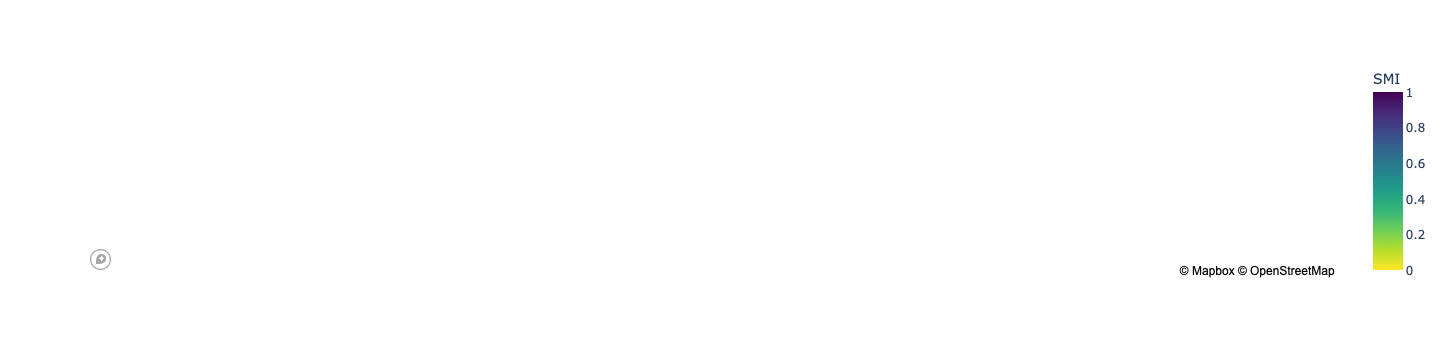

In [100]:
px.set_mapbox_access_token('pk.eyJ1IjoiY29qYWNrIiwiYSI6IkRTNjV1T2MifQ.EWzL4Qk-VvQoaeJBfE6VSA')

#use transform if you know EPSG (check epsg.io for further details
#transformer = Transformer.from_crs(6258, 4326)

#for manual definition:
#from pyproj import CRS
#sinu_crs = CRS.from_proj4("+proj=stere +lat_0=90 +lat_ts=90 +lon_0=-97 +k=1 +x_0=3450000 +y_0=7450000 +a=6378273 +b=6356889.449 +units=m +no_defs ")
#crs_4326 = CRS.from_epsg(4326)
#transformer = Transformer.from_crs(sinu_crs, crs_4326)

#lonx, latx = transformer.transform(xx=smi.SMI[-50].to_dataframe().dropna().index.get_level_values(1), yy=smi.SMI[-50].to_dataframe().dropna().index.get_level_values(0))

#or a simple and very rough hand made conversion
lonx = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(1)/75000.-48.
latx = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(0)/110000.+22.
fig = px.scatter_mapbox(smi.SMI[-50].to_dataframe().dropna(), lat=latx, lon=lonx,  color='SMI', hover_data=['time','SMI'],color_continuous_scale='viridis_r',range_color=(0.,1.), zoom=2)
fig.show()

In [112]:
drought = pd.DataFrame(index=pd.to_datetime(smi.time), columns=['p20','p10'])
for i in np.arange(len(drought)):
    drought.iloc[i,0] = (smi.SMI[i].to_dataframe().dropna().SMI<0.2).sum()/2540.
    drought.iloc[i,1] = (smi.SMI[i].to_dataframe().dropna().SMI<0.1).sum()/2540.

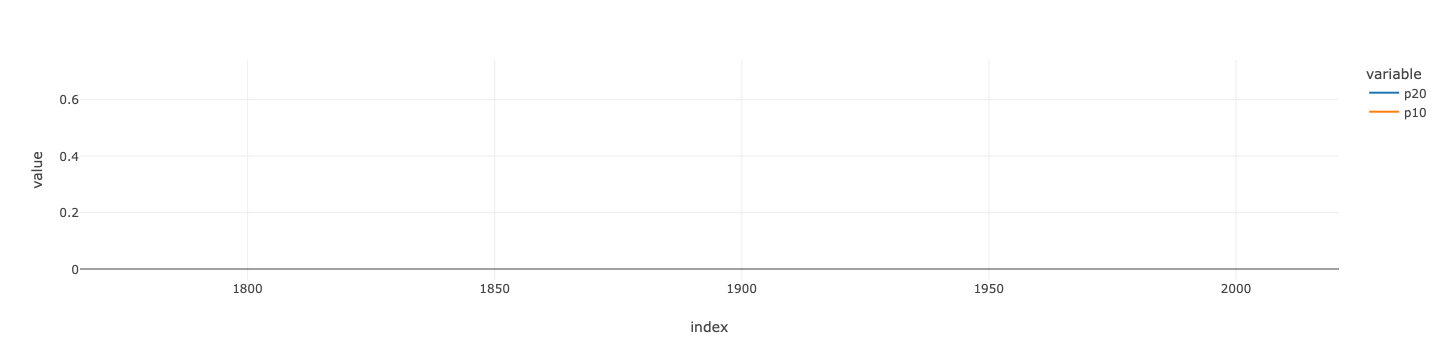

In [113]:
px.line(drought, template='none')

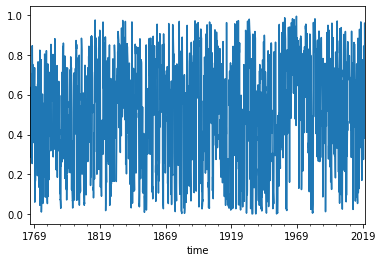

In [133]:
xcc = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(0).unique()
ycc = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(1).unique()
smi.sel(xc=xcc[10],yc=ycc[10]).SMI.to_dataframe().SMI.plot()

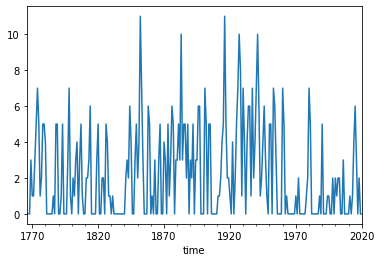

In [135]:
(smi.sel(xc=xcc[10],yc=ycc[10]).SMI.to_dataframe().SMI<0.2).resample('1Y').sum().plot()

In [168]:
smidy = (smi.SMI<0.2).resample(time="Y").sum()

drought1 = pd.DataFrame(index=pd.to_datetime(smidy.time), columns=['share_any','share_95','length_mean','length_95','length_max'])
for i in np.arange(len(drought1)):
    drought1.iloc[i,0] = (smidy[i].to_dataframe().SMI>0).sum()/2540.
    drought1.iloc[i,1] = (smidy[i].to_dataframe().SMI>smidy[i].to_dataframe().SMI.quantile(0.95)).sum()/2540.
    drought1.iloc[i,2] = smidy[i].to_dataframe().SMI.mean()
    drought1.iloc[i,3] = smidy[i].to_dataframe().SMI.quantile(0.95)
    drought1.iloc[i,4] = smidy[i].to_dataframe().SMI.max()

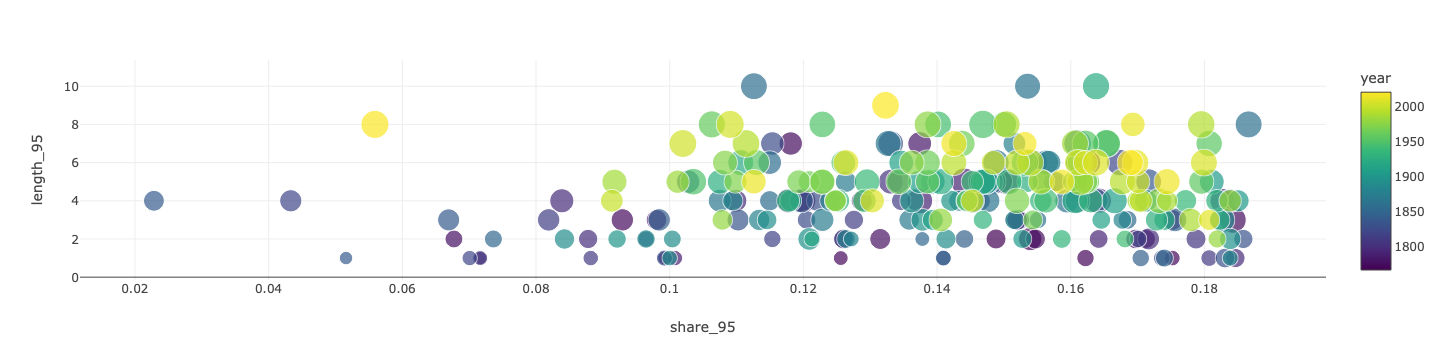

In [176]:
drought1['bubble_size'] = drought1.share_any*0.002
drought1['year'] = drought1.index.year
px.scatter(drought1.astype(float), x='share_95', y='length_95',size='bubble_size', color='year', template='none')